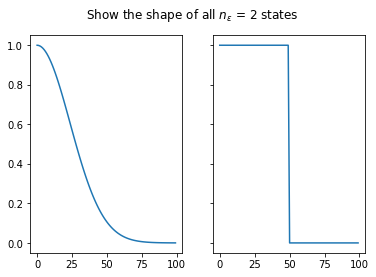

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
from sklearn.decomposition import PCA
import plotly.express as px
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from latent import latent
from redatuming import redatuming
from plot_redatuming import plot_redatuming
def g(n,x):
    if n==0:
        return math.e**(-9*x**2)
    elif n==1:
        return int(x<0.5)
    elif n==2:
        if x<0.3:
            return 3*x
        elif x<0.6:
            return 3*(0.6-x)
        else:
            return 0
    elif n==3:
        return math.cos(2*math.pi*x)
    elif n==4:
        return math.e**(-30*(x-0.5)**2)
    else:
        return np.inf
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True)
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0)
pca_cb = PCA(n_components=2)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=0)
MRA_training.generate_default()
MRA_pca.generate_default()
X = MRA_training.X
clear_output()
N_shifts = MRA_pca.shifts.reshape(-1,1)
N_states = np.repeat(MRA_pca.states,nt)
image_list = []
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
        if epoch % 10 == 0:
            clear_output(wait = True)
            _,Ns = latent(model,MRA_pca)
            N_reshaped = Ns.reshape(-1,q)
            pca_N = N_reshaped
            df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
            df_states = pd.DataFrame(N_states,columns=['state']).astype('object') 
            df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
            df = pd.concat([df,df_states,df_shifts],axis=1)
            fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift', title='q=%d,loss=%f'%(q,logs["loss"]))
            fig.update_layout(height=400)
            fig.show()
clear_output()
fig.show()

In [ ]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
#model.load_weights('./checkpoint/'+'p=3,q=2,add,normalize')
clear_output()

In [7]:
model.latentcat.drop.stddev = 2

In [8]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)
history = model.fit(X,X,epochs=1000,verbose=0,callbacks=[CustomCallback()])

For epoch 991, loss is 0.000979.
For epoch 992, loss is 0.000948.
For epoch 993, loss is 0.001004.
For epoch 994, loss is 0.001120.
For epoch 995, loss is 0.000995.
For epoch 996, loss is 0.001046.
For epoch 997, loss is 0.001064.
For epoch 998, loss is 0.001326.
For epoch 999, loss is 0.000973.


In [9]:
#model.save_weights('./checkpoint/'+'p=3,q=3,add,bn=true')

In [5]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(100):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j
MRA1, t1 = find(1,40)
MRA2, t2 = find(2,60)
redatum = redatuming(model,MRA1,MRA2,t1,t2)
clear_output()
fig = plot_redatuming(redatum)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
dim = 3
pca = PCA(n_components=dim)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)
N_reshaped = Ns.reshape(-1,q)
N_shifts = MRA_pca.shifts.reshape(-1,1)
if dim == 3:
    pca_N = N_reshaped
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    #df = df[df['state']==0]
    fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state', text='shift')
if dim ==2:
    pca_N = pca.fit_transform(N_reshaped)
    df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'][0:dim])
    df_states = pd.DataFrame(np.repeat(MRA_pca.states,nt),columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    fig = px.scatter(df, x='1st', y='2nd', color='state', text='shift')
fig.show()